## Setup

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from scipy.stats import kruskal
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from IPython.display import display
from scipy.stats import pearsonr
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import ttest_ind, f_oneway

In [69]:
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title



In [70]:
df = pd.read_csv(r'FinalEvAdoptionInFranceResults.csv')
# for col in df.columns:
#     values = df[col].dropna().astype(str)
#     split_vals = []
#     for val in values:
#         split_vals.extend([v.strip() for v in val.split(',') if v.strip()])
#     unique_vals = pd.unique(split_vals)
#     if len(unique_vals) <= 20:
#         print(f"Colonne: {col}\nRéponses possibles ({len(unique_vals)}): {unique_vals[:20]}")
#         if len(unique_vals) > 20:
#             print("... (troncature à 20 valeurs)")
#         print("-" * 60)
# print(list(df.columns))

## Cross analysis

In [71]:
# Unification, suppression des doublons, et usage de likert_map partout où pertinent

# 1. Recodage échelle 4 points (Likert)
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Tout à fait d'accord": 4,
    "Totalement d'accord": 4,
    "Tout à fait d’accord": 4,  # gestion des accents différents
    "\nPlutôt en désaccord\n\n": 2,
}

# 2. Variable cible : intention d’adopter (pour les non-possesseurs de VE)
df['intention_adopter'] = df["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(likert_map)

# 3. Score de connaissance (subjective)
connaissance_map = {
    "Pas du tout, je ne m’y suis jamais vraiment intéressé": 1,
    "Un peu, je connais quelques modèles et options": 2,
    "Assez bien, je vois passer des informations": 3,
    "Très bien, je suis régulièrement les nouveautés": 4
}
df['connaissance_score'] = df[connaissance_col].map(connaissance_map)

# 4. Score de connaissance objective : nombre d’aides connues
def count_aides(cell):
    if pd.isnull(cell) or not str(cell).strip():
        return 0
    return len([x for x in str(cell).split(',') if x.strip() and x.strip().lower() not in ["je ne sais pas", "aucune"]])
df['nb_aides_connues'] = df[aides_col].apply(count_aides)

# 5. Perception du coût
df['ve_trop_cher'] = df["Avez-vous l’impression que les véhicules électriques soient trop chers à l’achat ou à l’entretien ?\n"].map({"Oui": 1, "Non": -1, "Je ne sais pas": 0})

# 6. Nombre d’avantages économiques perçus
def count_avantages(cell):
    if pd.isnull(cell):
        return 0
    return len([x for x in str(cell).split(',') if x.strip() and x.strip().lower() != "aucun"])
df['nb_avantages_economiques'] = df["Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique)"].apply(count_avantages)

# 7. Perception de l’infrastructure (suffisante)
df['infra_suffisante'] = df["Pensez-vous que l’infrastructure de recharge est suffisante en France pour vous encourager à adopter un véhicule électrique ?"].map({"Oui": 1, "Non": 0})

# 8. Expérience négative avec l’infrastructure (au moins un problème rencontré)
def detect_pb_recharge(cell):
    if pd.isnull(cell):
        return 0
    return 1 if "oui" in str(cell).strip().lower() else 0
df['pb_recharge'] = df["Avez-vous déjà rencontré des difficultés pour recharger votre véhicule électrique ?\n"].apply(detect_pb_recharge)

# 9. Sensibilité environnementale (Likert)
df['sensibilite_env'] = df["Diriez-vous que : [Vous êtes sensible aux questions environnementales]"].map(likert_map)

# 10. Perception symbolique (geste pour la planète)
df['geste_planete'] = df["Que représente pour vous un véhicule 100% électrique ? (Un geste pour la planète)"].map({True: 1, False: 0})

# 11. Fit avec le mode de vie (Likert)
driving_exp_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"
df['fit_lifestyle'] = df[driving_exp_col].map(likert_map)

# 12. Influence sociale (opinion des pairs positive, Likert)
df['peer_positive'] = df["Vous diriez que [L'avis de votre entourage est positif envers le véhicule électrique]"].map(likert_map)

# 13. Utilité perçue des aides
df['utilite_aides'] = df["Est-ce que ces aides impactent votre envie d'adopter un véhicule électrique ?"].map({"Oui": 2, "Vaguement": 1, "Non": 0})

# 14. Connaissance LOA/LLD
df['connaissance_loa_lld'] = df["(Optionnel) Il existe plusieurs façons de financer un véhicule électrique: \nLOA (location avec option d’achat), la LLD (location longue durée), leasing social, crédit auto...\nL’une de ces options vous semblerait-elle adaptée à votre situation ?\n"].map({"Oui": 2, "Non ": 1, "Je ne sais pas": 0})

# 15. Motivations détaillées
df['motivation_aides'] = df["Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (🎁 Aides financières / fiscales)"].map({True: 1, False: 0})
df['motivation_confort'] = df["Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (🚗 Confort de conduite / technologie)"].map({True: 1, False: 0})

# 16. Barrières détaillées
df['barriere_info'] = df["Et vos principaux blocages ? (🧠 Manque d’information)"].map({True: 1, False: 0})
df['barriere_cout'] = df["Et vos principaux blocages ? (❗ Coût d’achat élevé)"].map({True: 1, False: 0})

# 17. Accès à la recharge à domicile
df['recharge_domicile'] = df["Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?"].str.contains("domicile", case=False, na=False).astype(int)

# 18. Connaissance opérateurs
df['nb_operateurs_connus'] = df["Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n"].apply(
    lambda x: 0 if pd.isnull(x) else len([v for v in str(x).split(',') if v.strip().lower() not in ["non", "je ne connais aucun de ces noms"]])
)

# 19. Score de knowledge gap
def knowledge_gap(row):
    gaps = 0
    if row['connaissance_score'] <= 2: gaps += 1
    if row['nb_aides_connues'] == 0: gaps += 1
    if row['nb_operateurs_connus'] == 0: gaps += 1
    return gaps
df['knowledge_gap'] = df.apply(knowledge_gap, axis=1)

# 20. Clarté des aspects pratiques (Likert)
df['clarte_pratique'] = df["Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]"].map(likert_map)

# 21. Perceptions symboliques détaillées
df['symbolique_modernite'] = df["Que représente pour vous un véhicule 100% électrique ? (Un symbole d’innovation et de modernité)"].map({True: 1, False: 0})
df['symbolique_avenir'] = df["Que représente pour vous un véhicule 100% électrique ? (L'avenir du transport)"].map({True: 1, False: 0})
df['symbolique_jeune'] = df["Que représente pour vous un véhicule 100% électrique ? (Une technologie encore trop jeune)"].map({True: 1, False: 0})

# 22. Expérience de controverses/incidents (Likert)
df['controverse_ev'] = df["Diriez-vous que : [Les polémiques autour des VE vous inquiètent]"].map(likert_map)

# 23. Nombre de VE connus dans l’entourage
def nb_ve_entourage(val):
    if pd.isnull(val): return 0
    val = val.lower()
    if "aucune" in val: return 0
    if "peu" in val: return 2
    if "plusieurs" in val: return 4
    if "beaucoup" in val: return 6
    return 0
df['nb_ve_entourage'] = df["Combien de personnes dans votre entourage utilisent un véhicule électrique ?\n"].apply(nb_ve_entourage)

# 24. Discussions avec les pairs (Likert)
df['discussions_pairs'] = df["Vous diriez que [Vous avez déjà échangé sur le sujet des véhicules électriques avec votre entourage]"].map(likert_map)

# 25. Clarté/confiance sources d’info
df['clarte_sources'] = df["Ces sources vous paraissent-elles claires et fiables ?\n"].map({
    "Oui, j’ai facilement trouvé ce que je cherchais": 2,
    "Pas toujours, il faut croiser les infos et c'était plutôt complexe de comprendre les offres et véhicules disponible sur le marché": 1,
    "Non, je trouve ça compliqué à comprendre, je n'ai jamais vu d'informations claires sur le sujet": 0,
    "Je ne me suis jamais renseigné(e)": 0
})

# 26. Communication de marque
df['comm_marque'] = df["Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (📢 Communication des marques)"].map({True: 1, False: 0})

# 27. Variables sociodémographiques
df['age'] = df[age_col]
df['region'] = df[region_col]
df['csp'] = df["Quelle est votre situation professionnelle actuelle ?\n"]

# 28. Nombre de véhicules et de personnes (conversion numérique)
df['nb_vehicules'] = pd.to_numeric(df['Combien de véhicules personnels utilisez-vous dans votre foyer ?'], errors='coerce')
df['nb_personnes'] = pd.to_numeric(df['Combien êtes-vous dans votre foyer ?'], errors='coerce')

# 29. Possession de VE
df['owns_ev'] = df[vehicle_cols[3]].fillna(False).astype(bool)


C:\Users\Mango\AppData\Local\Temp\ipykernel_32692\2505115847.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['owns_ev'] = df[vehicle_cols[3]].fillna(False).astype(bool)


Removing constant columns (zero variance): ['pb_recharge']
Optimization terminated successfully.
         Current function value: 0.309932
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              adopt_bin   No. Observations:                  180
Model:                          Logit   Df Residuals:                      152
Method:                           MLE   Df Model:                           27
Date:                Tue, 27 May 2025   Pseudo R-squ.:                  0.5514
Time:                        19:28:49   Log-Likelihood:                -55.788
converged:                       True   LL-Null:                       -124.37
Covariance Type:            nonrobust   LLR p-value:                 1.051e-16
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                

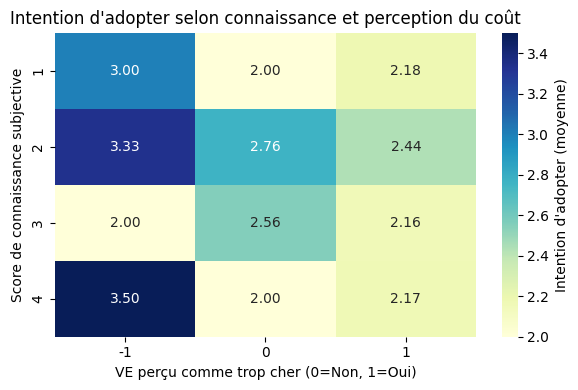

connaissance_score: ANOVA F = 2.51, p = 0.0599
nb_aides_connues: ANOVA F = 2.94, p = 0.0092
ve_trop_cher: ANOVA F = 2.32, p = 0.1010
nb_avantages_economiques: ANOVA F = 5.06, p = 0.0000
infra_suffisante: ANOVA F = 0.52, p = 0.4707
pb_recharge: ANOVA F = nan, p = nan
sensibilite_env: ANOVA F = 2.17, p = 0.0923
geste_planete: ANOVA F = 28.27, p = 0.0000
fit_lifestyle: ANOVA F = 45.95, p = 0.0000
peer_positive: ANOVA F = 16.73, p = 0.0000
utilite_aides: ANOVA F = 33.28, p = 0.0000
connaissance_loa_lld: ANOVA F = 14.22, p = 0.0000
motivation_aides: ANOVA F = 0.04, p = 0.8471
motivation_confort: ANOVA F = 11.01, p = 0.0011
barriere_info: ANOVA F = 0.00, p = 0.9898
barriere_cout: ANOVA F = 0.00, p = 0.9597
recharge_domicile: ANOVA F = 2.83, p = 0.0939
nb_operateurs_connus: ANOVA F = 1.29, p = 0.2422
knowledge_gap: ANOVA F = 0.53, p = 0.6603
clarte_pratique: ANOVA F = 14.61, p = 0.0000
symbolique_modernite: ANOVA F = 3.27, p = 0.0720
symbolique_avenir: ANOVA F = 24.08, p = 0.0000
symbolique_j

C:\Users\Mango\AppData\Local\Temp\ipykernel_32692\1307981760.py:51: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  fval, pval = f_oneway(*groups)


In [72]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Régression logistique multivariée (intention forte = 1 si score >=3)
df['adopt_bin'] = (df['intention_adopter'] >= 3).astype(int)
features = [
    'connaissance_score', 'nb_aides_connues', 've_trop_cher', 'nb_avantages_economiques',
    'infra_suffisante', 'pb_recharge', 'sensibilite_env', 'geste_planete', 'fit_lifestyle',
    'peer_positive', 'utilite_aides', 'connaissance_loa_lld', 'motivation_aides',
    'motivation_confort', 'barriere_info', 'barriere_cout', 'recharge_domicile',
    'nb_operateurs_connus', 'knowledge_gap', 'clarte_pratique', 'symbolique_modernite',
    'symbolique_avenir', 'symbolique_jeune', 'controverse_ev', 'nb_ve_entourage',
    'discussions_pairs', 'clarte_sources', 'comm_marque'
]

X = df[features].dropna()
y = df.loc[X.index, 'adopt_bin']
if X.empty or y.empty:
    print("Pas assez de données complètes pour ajuster le modèle logistique.")
else:
    # Remove constant columns to avoid singular matrix error
    nunique = X.apply(pd.Series.nunique)
    constant_cols = nunique[nunique <= 1].index.tolist()
    if constant_cols:
        print(f"Removing constant columns (zero variance): {constant_cols}")
        X = X.drop(columns=constant_cols)
    X = sm.add_constant(X)
    try:
        model = sm.Logit(y, X).fit()
        print(model.summary())
    except np.linalg.LinAlgError as e:
        print(f"LinAlgError: {e}. Try removing more collinear features.")

# 2. Heatmap croisée : connaissance × coût perçu
pivot = df.pivot_table(index='connaissance_score', columns='ve_trop_cher', values='intention_adopter', aggfunc='mean')
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': "Intention d'adopter (moyenne)"})
plt.xlabel("VE perçu comme trop cher (0=Non, 1=Oui)")
plt.ylabel("Score de connaissance subjective")
plt.title("Intention d'adopter selon connaissance et perception du coût")
plt.tight_layout()
plt.show()

# 3. ANOVA pour chaque variable explicative (quantitative ou ordinale)
from scipy.stats import f_oneway
for var in features:
    if df[var].nunique() > 1:
        groups = [g['intention_adopter'].dropna() for _, g in df.groupby(var)]
        if len(groups) > 1:
            fval, pval = f_oneway(*groups)
            print(f"{var}: ANOVA F = {fval:.2f}, p = {pval:.4f}")

In [73]:
# 1. Blocages (sélection multiple)
blocage_cols = [col for col in df.columns if col.startswith("Et vos principaux blocages ? (")]

def prop_selection(cols, mask, label):
    print(f"\n--- {label} ---")
    prop = df.loc[mask, cols].mean().sort_values(ascending=False)
    for col, val in prop.items():
        print(f"{col}: {val:.2%}")
    return prop

mask_owner = df['owns_ev'] == True
mask_non_owner = df['owns_ev'] == False

print("Blocages (propriétaires VE) :")
prop_selection(blocage_cols, mask_owner, "Propriétaires VE")
print("Blocages (non-propriétaires VE) :")
prop_selection(blocage_cols, mask_non_owner, "Non-propriétaires VE")

# 2. Motivations (sélection multiple)
# Propriétaires : "Pourquoi avez-vous décidé d'adopter un véhicule électrique, quelles ont été vos motivations ? ("
motivation_owner_cols = [col for col in df.columns if col.startswith("Pourquoi avez-vous décidé d'adopter un \nvéhicule électrique, quelles ont été vos motivations ? (")]
# Non-propriétaires : "Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? ("
motivation_nonowner_cols = [col for col in df.columns if col.startswith("Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (")]

print("Motivations (propriétaires VE) :")
prop_selection(motivation_owner_cols, mask_owner, "Propriétaires VE")
print("Motivations (non-propriétaires VE) :")
prop_selection(motivation_nonowner_cols, mask_non_owner, "Non-propriétaires VE")



Blocages (propriétaires VE) :

--- Propriétaires VE ---
Et vos principaux blocages ? (😰 Autonomie limitée): 69.70%
Et vos principaux blocages ? (❗ Coût d’achat élevé): 57.58%
Et vos principaux blocages ? (⚡ Infrastructure insuffisante): 39.39%
Et vos principaux blocages ? (👂Changement d’habitudes déstabilisant): 15.15%
Et vos principaux blocages ? (Autre): 15.15%
Et vos principaux blocages ? (📉 Perte de confiance (Tesla, incidents)): 12.12%
Et vos principaux blocages ? (🧠 Manque d’information): 12.12%
Et vos principaux blocages ? (📛 Manque d’intérêt personnel): 9.09%
Et vos principaux blocages ? (💸 Offres de financement peu claires): 6.06%
Blocages (non-propriétaires VE) :

--- Non-propriétaires VE ---
Et vos principaux blocages ? (😰 Autonomie limitée): 77.89%
Et vos principaux blocages ? (❗ Coût d’achat élevé): 72.86%
Et vos principaux blocages ? (⚡ Infrastructure insuffisante): 61.31%
Et vos principaux blocages ? (📉 Perte de confiance (Tesla, incidents)): 27.64%
Et vos principaux blo

Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (💸 Économies à long terme)                   0.492462
Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (🌱 Respect de vos convictions)               0.452261
Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (🚗 Confort de conduite / technologie)        0.386935
Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (🎁 Aides financières / fiscales)             0.331658
Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (⚡ Facilité de recharge)                     0.331658
Si vous envisagiez d'adopter un véhicule entièrement électrique, quelles serait vos principales motivations ? (🛑 Contraintes réglementaires (ex : ZFE))    0.326633
Si vous envisagi

## Blocages principaux

| Blocage                                                    | % Propriétaires VE | % Non-propriétaires VE |
|------------------------------------------------------------|--------------------|-----------------------|
| 😰 Autonomie limitée                                       | 69.70%             | 77.89%                |
| ❗ Coût d’achat élevé                                       | 57.58%             | 72.86%                |
| ⚡ Infrastructure insuffisante                              | 39.39%             | 61.31%                |
| 👂 Changement d’habitudes déstabilisant                    | 15.15%             | 13.57%                |
| Autre                                                      | 15.15%             | 10.55%                |
| 📉 Perte de confiance (Tesla, incidents)                   | 12.12%             | 27.64%                |
| 🧠 Manque d’information                                    | 12.12%             | 14.57%                |
| 📛 Manque d’intérêt personnel                              | 9.09%              | 26.63%                |
| 💸 Offres de financement peu claires                       | 6.06%              | 13.07%                |

---

## Motivations principales

### Propriétaires de VE

| Motivation                                                 | % Propriétaires VE |
|------------------------------------------------------------|--------------------|
| 🚗 Confort de conduite / technologie                       | 63.64%             |
| 🌱 Respect de vos convictions                              | 48.48%             |
| 💸 Économies à long terme                                  | 48.48%             |
| ⚡ Facilité de recharge                                    | 42.42%             |
| 🚀 Image de modernité / innovation                         | 30.30%             |
| 🎁 Aides financières / fiscales                            | 27.27%             |
| 👥 Avis de l'entourage                                     | 18.18%             |
| Autre                                                      | 15.15%             |
| 🛑 Contraintes réglementaires (ex : ZFE)                   | 12.12%             |
| 📢 Communication des marques                               | 3.03%              |

### Non-propriétaires de VE

| Motivation                                                 | % Non-propriétaires VE |
|------------------------------------------------------------|-----------------------|
| 💸 Économies à long terme                                  | 49.25%                |
| 🌱 Respect de vos convictions                              | 45.23%                |
| 🚗 Confort de conduite / technologie                       | 38.69%                |
| 🎁 Aides financières / fiscales                            | 33.17%                |
| ⚡ Facilité de recharge                                    | 33.17%                |
| 🛑 Contraintes réglementaires (ex : ZFE)                   | 32.66%                |
| 🚀 Image de modernité / innovation                         | 16.08%                |
| 👥 Avis de l'entourage                                     | 11.56%                |
| Autre                                                      | 7.54%                 |
| 📢 Communication des marques                               | 5.53%                 |

---

### Analyse rapide

- **Blocages** : L’autonomie limitée, le coût d’achat et l’infrastructure sont les trois principaux blocages pour tous, mais ils sont encore plus cités par les non-propriétaires.
- **Motivations** : Les propriétaires mettent en avant le confort, les convictions et les économies ; les non-propriétaires citent surtout les économies, les convictions et le confort.
- Les non-propriétaires sont plus nombreux à citer la perte de confiance, le manque d’intérêt personnel et les offres de financement peu claires comme blocages.